# Metric Learning 

In [8]:
import tensorflow as tf 
import random 
import matplotlib.pyplot as plt 
import numpy as np 

from PIL import Image 
from sklearn.metrics import ConfusionMatrixDisplay
from collections import defaultdict



In [24]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() 
x_train.shape, y_train.shape 

((50000, 32, 32, 3), (50000, 1))

In [114]:
x_train = x_train / 255.
x_test = x_test / 255.

In [9]:
# np.squeeze(y_train).shape
print(list(np.unique(y_train)) ) 
print(defaultdict(list)) 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
defaultdict(<class 'list'>, {})


In [115]:
y_train_squeeze = np.squeeze(y_train)
class_idx_to_train_idxs = defaultdict(list)
print(class_idx_to_train_idxs)

for y_train_idx, y in enumerate(y_train_squeeze):
    class_idx_to_train_idxs[y].append(y_train_idx)
    
    
# print(class_idx_to_train_idxs)

defaultdict(<class 'list'>, {})


In [116]:
class_idx_to_test_idxs = defaultdict(list) 

for y_train_idx, y in enumerate(np.squeeze(y_train)): 
    class_idx_to_test_idxs[y].append(y_train_idx)
    

In [117]:
num_classes = 10 
RES_SIZE = 32 

In [118]:
class AnchorPostivePairs(tf.keras.utils.Sequence): 
    def __init__(self, num_batchs):
        self.num_batchs = num_batchs 
        
    def __len__(self):
        return self.num_batchs 
    
    def __getitem__(self, _idx): 
        x = np.empty((2, num_classes, RES_SIZE, RES_SIZE, 3), dtype=np.float32)
        
        for  class_idx in range(num_classes): 
            examples_for_class = class_idx_to_train_idxs[class_idx]
            
            # random_idx = random.choice(examples_for_class)
            # anchor_idx = random_idx
            # positive_idx = random_idx
        
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)            
            while positive_idx == anchor_idx:
                # print(positive_idx) 
                # print(anchor_idx)
                positive_idx = random.choice(examples_for_class)
                
            x[0, class_idx] = x_train[anchor_idx]
            x[1, class_idx] = x_train[positive_idx]
            
        return x

In [119]:
def show_collage(examples):
    box_size = RES_SIZE + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Double size for visualisation.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage

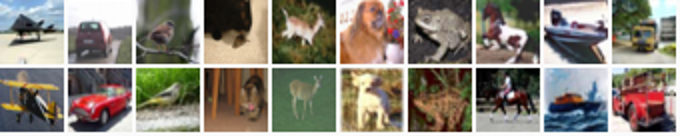

In [120]:
# idx = random.choice(class_idx_to_test_idxs[0])
examples = next(iter(AnchorPostivePairs(num_batchs=1)))
show_collage(examples) 


In [121]:
class EmbeddingModel(tf.keras.Model):
    
    def train_step(self, data): 
        
        if isinstance(data, tuple):
            data = data[0]
            
        anchors, postive = data[0], data[1] 
        
        with tf.GradientTape() as tape: 
            # prediction 
            anchor_embeddings = self(anchors, training=True)
            positive_embeddings = self(postive, training=True) 
            
            similarities = tf.einsum(
                "ae, pe-> ap", anchor_embeddings, positive_embeddings
            )
            
            temperature = 0.2 
            similarities /= temperature
            
            sparse_labels = tf.range(num_classes)
            loss = self.compiled_loss(sparse_labels, similarities)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.compiled_metrics.update_state(sparse_labels, similarities)
        
        return {m.name : m.result() for m in self.metrics} 

In [122]:
inputs = tf.keras.layers.Input(shape=(RES_SIZE, RES_SIZE, 3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
embeddings = tf.keras.layers.Dense(units=8, activation=None)(x)
embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

model = EmbeddingModel(inputs, embeddings)

In [123]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    metrics=['accuracy']
)


In [124]:

hist = model.fit(AnchorPostivePairs(num_batchs=1000), epochs=30)

Epoch 1/30
1000/1000 [==============================] - 4s 3ms/step - loss: 2.1694 - accuracy: 0.1789
Epoch 2/30
1000/1000 [==============================] - 3s 3ms/step - loss: 2.0658 - accuracy: 0.2111
Epoch 3/30
1000/1000 [==============================] - 3s 3ms/step - loss: 2.0054 - accuracy: 0.2275
Epoch 4/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.9653 - accuracy: 0.2453
Epoch 5/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.9331 - accuracy: 0.2531
Epoch 6/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.9101 - accuracy: 0.2645
Epoch 7/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.8777 - accuracy: 0.2836
Epoch 8/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.8588 - accuracy: 0.2842
Epoch 9/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.8365 - accuracy: 0.2946
Epoch 10/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.809

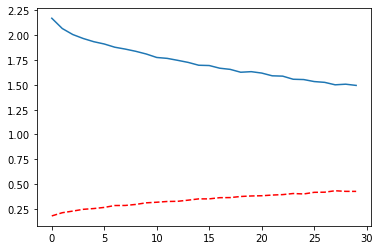

In [125]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'], 'r--')
plt.show() 

In [126]:
near_neighbours_per_example = 10

embeddings = model.predict(x_test)
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]

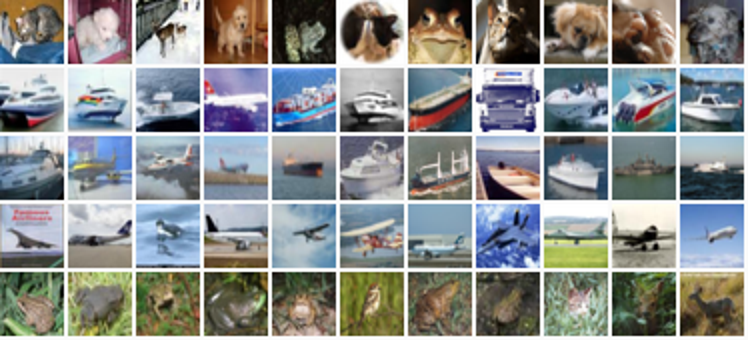

In [128]:
num_collage_examples = 5

examples = np.empty(
    (
        num_collage_examples,
        near_neighbours_per_example + 1,
        RES_SIZE,
        RES_SIZE,
        3,
    ),
    dtype=np.float32,
)
for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = x_test[row_idx]
    anchor_near_neighbours = reversed(near_neighbours[row_idx][:-1])
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = x_test[nn_idx]

show_collage(examples)

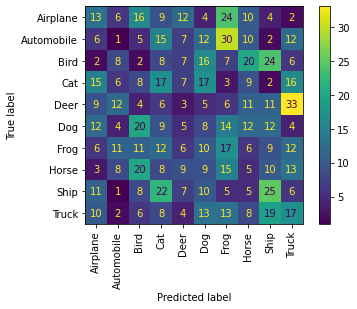

In [105]:
confusion_matrix = np.zeros((num_classes, num_classes))

# For each class.
for class_idx in range(num_classes):
    # Consider 10 examples.
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        # And count the classes of its near neighbours.
        for nn_idx in near_neighbours[y_test_idx][:-1]:
            nn_class_idx = y_test[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

# Display a confusion matrix.
labels = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()

In [106]:
a = np.array([[1,2],[3,4]]) 
b = np.array([[2,3],[4,5]])

In [109]:
np.einsum('ae, pe->ap', a, b)

array([[ 8, 14],
       [18, 32]])